In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform,
download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Testdata: ",len(test_loader))


100%|██████████| 9912422/9912422 [00:00<00:00, 106090528.81it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 20159043.74it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23925866.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15301629.53it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data: 50000 Validation data: 10000 Testdata:  10000


In [3]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available())
else
                      "cpu")

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [5]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [6]:
def fit(model, device, train_loader, val_loader, epochs):
    data_loader = {'train': train_loader, 'val': val_loader}
    print("Fitting the model...")
    train_loss, val_loss = [], []
    for epoch in range(epochs):
        loss_per_epoch, val_loss_per_epoch = 0, 0
        for phase in ('train', 'val'):
            for i, data in enumerate(data_loader[phase]):
                input, label = data[0].to(device), data[1].to(device)
                output = model(input)
                # calculating loss on the output
                loss = criterion(output, label)
                if phase == 'train':
                    optimizer.zero_grad()
                    # grad calc w.r.t Loss func
                    loss.backward()
                    # update weights
                    optimizer.step()
                    loss_per_epoch += loss.item()
                else:
                    val_loss_per_epoch += loss.item()
        scheduler.step(val_loss_per_epoch / len(val_loader))
        print("Epoch: {} Loss: {} Val_Loss:{}".format(epoch + 1, loss_per_epoch / len(train_loader),
                                                        val_loss_per_epoch / len(val_loader)))
        train_loss.append(loss_per_epoch / len(train_loader))
        val_loss.append(val_loss_per_epoch / len(val_loader))
    return train_loss, val_loss

In [7]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.2928575719680116 Val_Loss:0.13062999006297035
Epoch: 2 Loss: 0.11498913675380845 Val_Loss:0.10227427207166918
Epoch: 3 Loss: 0.08779443793070163 Val_Loss:0.09809071227737945
Epoch: 4 Loss: 0.07746287185492806 Val_Loss:0.08712977170943607
Epoch: 5 Loss: 0.07107059697258587 Val_Loss:0.08397549056319695
Epoch: 6 Loss: 0.06403040230038518 Val_Loss:0.08107688158920634
Epoch: 7 Loss: 0.06027601041469805 Val_Loss:0.08141431753820322
Epoch: 8 Loss: 0.06058862540579199 Val_Loss:0.07695784044722027
Epoch: 9 Loss: 0.05730316520147742 Val_Loss:0.08100152818661943
Epoch: 10 Loss: 0.05388917162762338 Val_Loss:0.08052466538195754


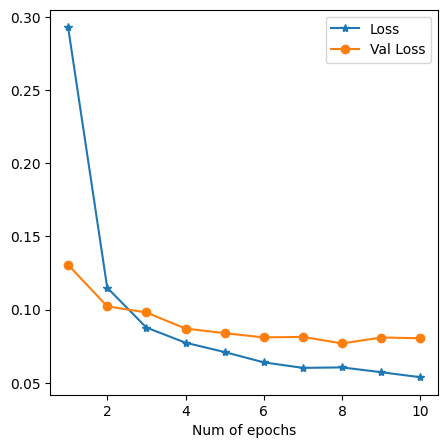

In [8]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [18]:
def fgsm_attack(input, epsilon, data_grad):
    pert_out = input + epsilon * data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    return pert_out

def ifgsm_attack(input, epsilon, data_grad):
    iter = 10
    alpha = epsilon / iter
    pert_out = input
    for i in range(iter - 1):
        pert_out = pert_out + alpha * data_grad.sign()
        pert_out = torch.clamp(pert_out, 0, 1)
        if torch.norm((pert_out - input), p=float('inf')) > epsilon:
            break
    return pert_out

def mifgsm_attack(input, epsilon, data_grad):
    iter = 10
    decay_factor = 1.0
    pert_out = input
    alpha = epsilon / iter
    g = 0
    for i in range(iter - 1):
        g = decay_factor * g + data_grad / torch.norm(data_grad, p=1)
        pert_out = pert_out + alpha * torch.sign(g)
        pert_out = torch.clamp(pert_out, 0, 1)
        if torch.norm((pert_out - input), p=float('inf')) > epsilon:
            break
    return pert_out


In [19]:
def test(model, device, test_loader, epsilon, attack):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        if attack == "fgsm":
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
        elif attack == "ifgsm":
            perturbed_data = ifgsm_attack(data, epsilon, data_grad)
        elif attack == "mifgsm":
            perturbed_data = mifgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples


Epsilon: 0	Test Accuracy = 9705 / 10000 = 0.9705
Epsilon: 0.007	Test Accuracy = 9677 / 10000 = 0.9677
Epsilon: 0.01	Test Accuracy = 9661 / 10000 = 0.9661
Epsilon: 0.02	Test Accuracy = 9585 / 10000 = 0.9585
Epsilon: 0.03	Test Accuracy = 9544 / 10000 = 0.9544
Epsilon: 0.05	Test Accuracy = 9353 / 10000 = 0.9353
Epsilon: 0.1	Test Accuracy = 8538 / 10000 = 0.8538
Epsilon: 0.2	Test Accuracy = 5659 / 10000 = 0.5659
Epsilon: 0.3	Test Accuracy = 3043 / 10000 = 0.3043


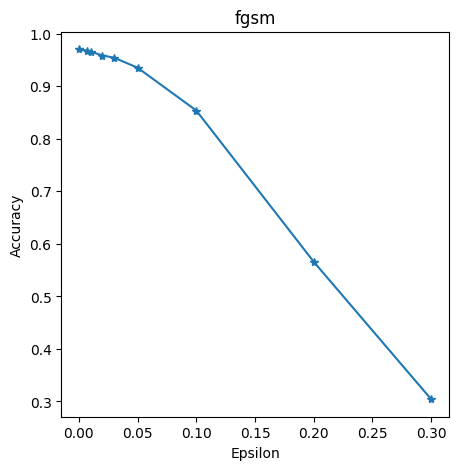

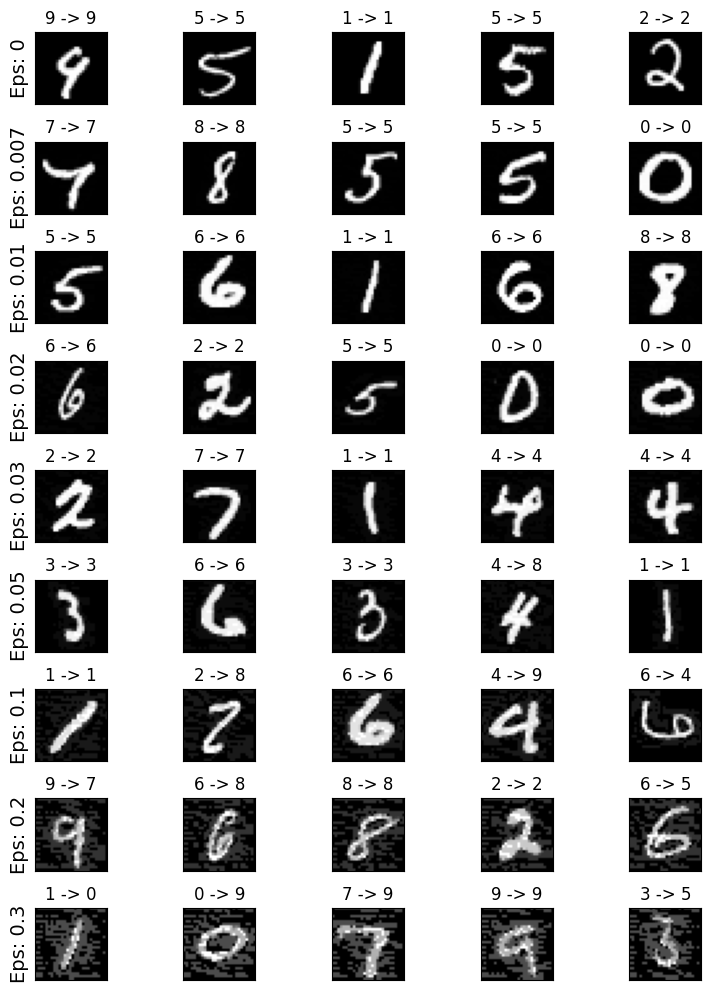

Epsilon: 0	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.007	Test Accuracy = 9673 / 10000 = 0.9673
Epsilon: 0.01	Test Accuracy = 9661 / 10000 = 0.9661
Epsilon: 0.02	Test Accuracy = 9590 / 10000 = 0.959
Epsilon: 0.03	Test Accuracy = 9557 / 10000 = 0.9557
Epsilon: 0.05	Test Accuracy = 9423 / 10000 = 0.9423
Epsilon: 0.1	Test Accuracy = 8803 / 10000 = 0.8803
Epsilon: 0.2	Test Accuracy = 6339 / 10000 = 0.6339
Epsilon: 0.3	Test Accuracy = 3744 / 10000 = 0.3744


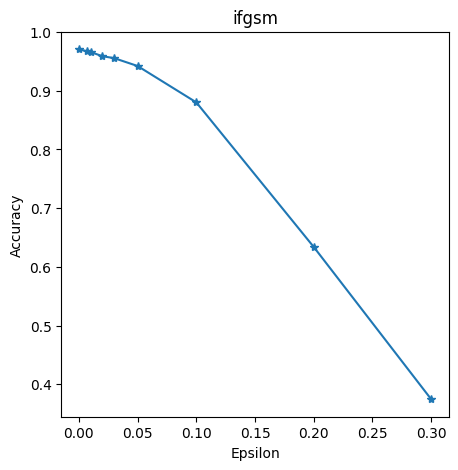

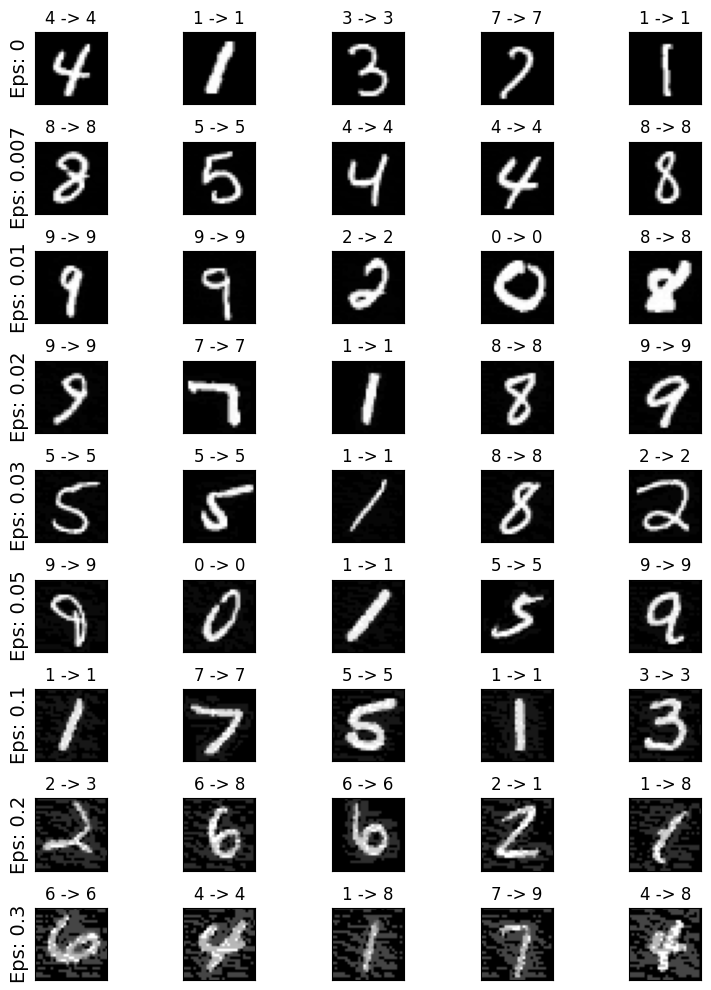

Epsilon: 0	Test Accuracy = 9670 / 10000 = 0.967
Epsilon: 0.007	Test Accuracy = 9690 / 10000 = 0.969
Epsilon: 0.01	Test Accuracy = 9690 / 10000 = 0.969
Epsilon: 0.02	Test Accuracy = 9590 / 10000 = 0.959
Epsilon: 0.03	Test Accuracy = 9545 / 10000 = 0.9545
Epsilon: 0.05	Test Accuracy = 9420 / 10000 = 0.942
Epsilon: 0.1	Test Accuracy = 8766 / 10000 = 0.8766
Epsilon: 0.2	Test Accuracy = 6312 / 10000 = 0.6312
Epsilon: 0.3	Test Accuracy = 3719 / 10000 = 0.3719


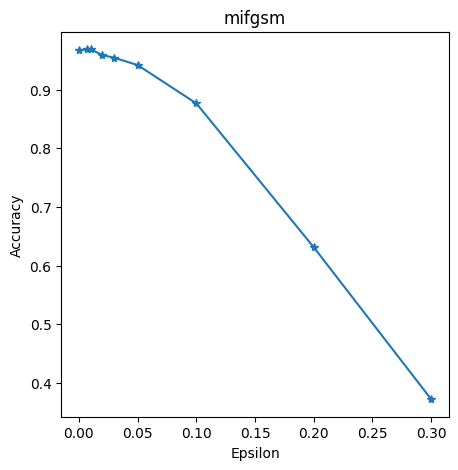

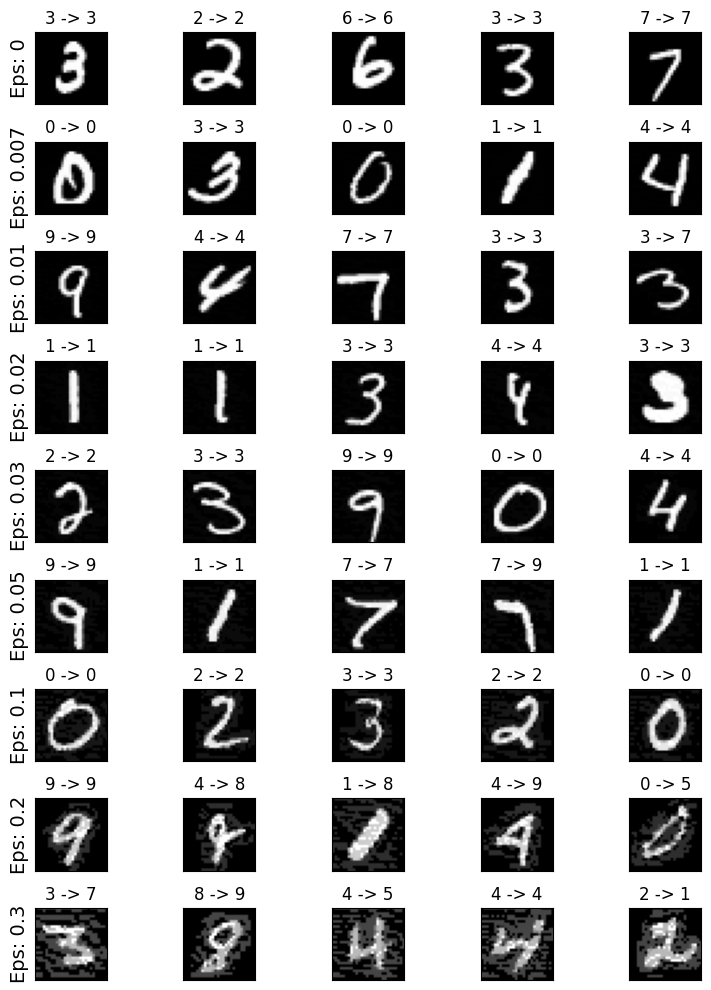

In [22]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm", "ifgsm", "mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
        acc, ex = test(model, device, test_loader, eps, attack)
        accuracies.append(acc)
        examples.append(ex)

    plt.figure(figsize=(5, 5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    cnt = 0
    plt.figure(figsize=(8, 10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons), len(examples[0]), cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
            orig, adv, ex = examples[i][j]
            plt.title("{} -> {}".format(orig, adv))
            plt.imshow(ex, cmap="gray")

    plt.tight_layout()
    plt.show()


In [23]:
class NetF(nn.Module):
    def __init__(self):
        super(NetF, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

class NetF1(nn.Module):
    def __init__(self):
        super(NetF1, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(4608, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [24]:
def fit(model, device, optimizer, scheduler, criterion, train_loader, val_loader, Temp, epochs):
    data_loader = {'train': train_loader, 'val': val_loader}
    print("Fitting the model...")
    train_loss, val_loss = [], []
    for epoch in range(epochs):
        loss_per_epoch, val_loss_per_epoch = 0, 0
        for phase in ('train', 'val'):
            for i, data in enumerate(data_loader[phase]):
                input, label = data[0].to(device), data[1].to(device)
                output = model(input)
                output = F.log_softmax(output/Temp, dim=1)
                # calculating loss on the output
                loss = criterion(output, label)
                if phase == 'train':
                    optimizer.zero_grad()
                    # grad calc w.r.t Loss func
                    loss.backward()
                    # update weights
                    optimizer.step()
                loss_per_epoch += loss.item()
            else:
                val_loss_per_epoch += loss.item()
        scheduler.step(val_loss_per_epoch/len(val_loader))
        print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1, loss_per_epoch/len(train_loader), val_loss_per_epoch/len(val_loader)))
        train_loss.append(loss_per_epoch/len(train_loader))
        val_loss.append(val_loss_per_epoch/len(val_loader))
    return train_loss, val_loss


def test(model, device, test_loader, epsilon, Temp, attack):
    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        output = F.log_softmax(output/Temp, dim=1)
        init_pred = output.max(1, keepdim=True)[1]
        if init_pred.item() != target.item():
            continue
        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        if attack == "fgsm":
            perturbed_data = fgsm_attack(data, epsilon, data_grad)
        elif attack == "ifgsm":
            perturbed_data = ifgsm_attack(data, epsilon, data_grad)
        elif attack == "mifgsm":
            perturbed_data = mifgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples


In [25]:
def defense(device, train_loader, val_loader, test_loader, epochs, Temp, epsilons):
    modelF = NetF().to(device)
    optimizerF = optim.Adam(modelF.parameters(), lr=0.0001, betas=(0.9, 0.999))
    schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
    modelF1 = NetF1().to(device)
    optimizerF1 = optim.Adam(modelF1.parameters(), lr=0.0001, betas=(0.9, 0.999))
    schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
    criterion = nn.NLLLoss()

    lossF, val_lossF = fit(modelF, device, optimizerF, schedulerF, criterion, train_loader, val_loader, Temp, epochs)

    fig = plt.figure(figsize=(5, 5))
    plt.plot(np.arange(1, epochs + 1), lossF, "*-", label="Loss")
    plt.plot(np.arange(1, epochs + 1), val_lossF, "o-", label="Val Loss")
    plt.title("Network F")
    plt.xlabel("Num of epochs")
    plt.legend()
    plt.show()

    # converting target labels to soft labels
    for data in train_loader:
        input, label = data[0].to(device), data[1].to(device)
        softlabel = F.log_softmax(modelF(input), dim=1)
        data[1] = softlabel

    lossF1, val_lossF1 = fit(modelF1, device, optimizerF1, schedulerF1, criterion, train_loader, val_loader, Temp, epochs)

    fig = plt.figure(figsize=(5, 5))
    plt.plot(np.arange(1, epochs + 1), lossF1, "*-", label="Loss")
    plt.plot(np.arange(1, epochs + 1), val_lossF1, "o-", label="Val Loss")
    plt.title("Network F'")
    plt.xlabel("Num of epochs")
    plt.legend()
    plt.show()

    model = NetF1().to(device)
    model.load_state_dict(modelF1.state_dict())

    for attack in ("fgsm", "ifgsm", "mifgsm"):
        accuracies = []
        examples = []
        for eps in epsilons:
            acc, ex = test(model, device, test_loader, eps, 1, "fgsm")
            accuracies.append(acc)
            examples.append(ex)

        plt.figure(figsize=(5, 5))
        plt.plot(epsilons, accuracies, "*-")
        plt.title(attack)
        plt.xlabel("Epsilon")
        plt.ylabel("Accuracy")
        plt.show()

        cnt = 0
        plt.figure(figsize=(8, 10))
        for i in range(len(epsilons)):
            for j in range(len(examples[i])):
                cnt += 1
                plt.subplot(len(epsilons), len(examples[0]), cnt)
                plt.xticks([], [])
                plt.yticks([], [])
                if j == 0:
                    plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
                orig, adv, ex = examples[i][j]
                plt.title("{} -> {}".format(orig, adv))
                plt.imshow(ex, cmap="gray")

        plt.tight_layout()
        plt.show()

Fitting the model...
Epoch: 1 Loss: 0.6718880483684055 Val_Loss: 3.760543842508923e-05
Epoch: 2 Loss: 0.4419446175480625 Val_Loss: 5.406180173158646e-05
Epoch: 3 Loss: 0.3516119630672012 Val_Loss: 1.6444960856460966e-07
Epoch: 4 Loss: 0.26628957716985746 Val_Loss: 6.257741706212983e-06
Epoch: 5 Loss: 0.2112781667700724 Val_Loss: 7.245366596616804e-05
Epoch: 6 Loss: 0.1749388423935393 Val_Loss: 1.1741527032427257e-08
Epoch: 7 Loss: 0.15302881142084387 Val_Loss: 4.841066932567628e-06
Epoch: 8 Loss: 0.13980367614191172 Val_Loss: 9.971153037622571e-06
Epoch: 9 Loss: 0.1292070183302236 Val_Loss: 7.867782187531703e-10
Epoch: 10 Loss: 0.12276888819906075 Val_Loss: 6.678608804782016e-06


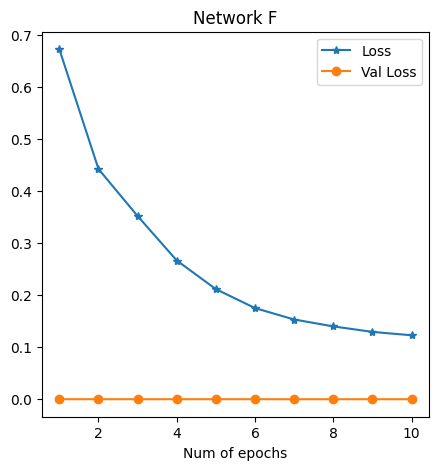

Fitting the model...
Epoch: 1 Loss: 0.8731193085341222 Val_Loss: 8.354537282139062e-06
Epoch: 2 Loss: 0.6472536788412092 Val_Loss: 8.132585743442178e-06
Epoch: 3 Loss: 0.580387904269018 Val_Loss: 0.0001069687694311142
Epoch: 4 Loss: 0.5324863605118745 Val_Loss: 0.00024034434854984283
Epoch: 5 Loss: 0.488611796620387 Val_Loss: 1.2676011025905609e-05
Epoch: 6 Loss: 0.448622796820559 Val_Loss: 0.00022948874831199646
Epoch: 7 Loss: 0.4064855647303159 Val_Loss: 1.7645734362304211e-06
Epoch: 8 Loss: 0.40459266735401966 Val_Loss: 7.141299710056046e-05
Epoch: 9 Loss: 0.3896351449284447 Val_Loss: 5.50084300339222e-06
Epoch: 10 Loss: 0.38542469227644016 Val_Loss: 1.5529074089135973e-05


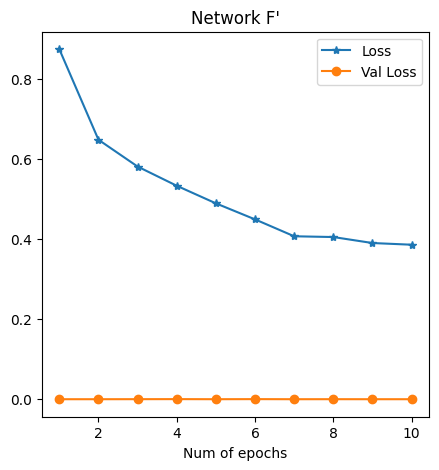

Epsilon: 0	Test Accuracy = 8590 / 10000 = 0.859
Epsilon: 0.007	Test Accuracy = 8586 / 10000 = 0.8586
Epsilon: 0.01	Test Accuracy = 8583 / 10000 = 0.8583
Epsilon: 0.02	Test Accuracy = 8507 / 10000 = 0.8507
Epsilon: 0.03	Test Accuracy = 8564 / 10000 = 0.8564
Epsilon: 0.05	Test Accuracy = 8552 / 10000 = 0.8552
Epsilon: 0.1	Test Accuracy = 8476 / 10000 = 0.8476
Epsilon: 0.2	Test Accuracy = 8350 / 10000 = 0.835
Epsilon: 0.3	Test Accuracy = 8234 / 10000 = 0.8234


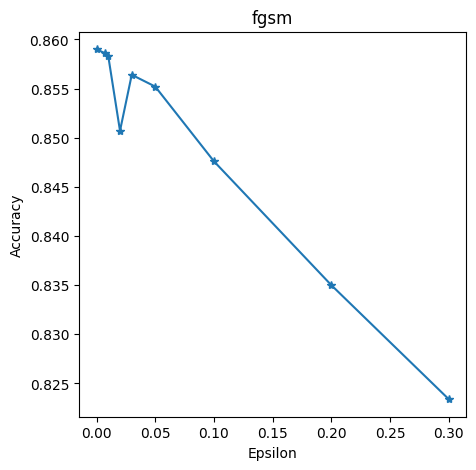

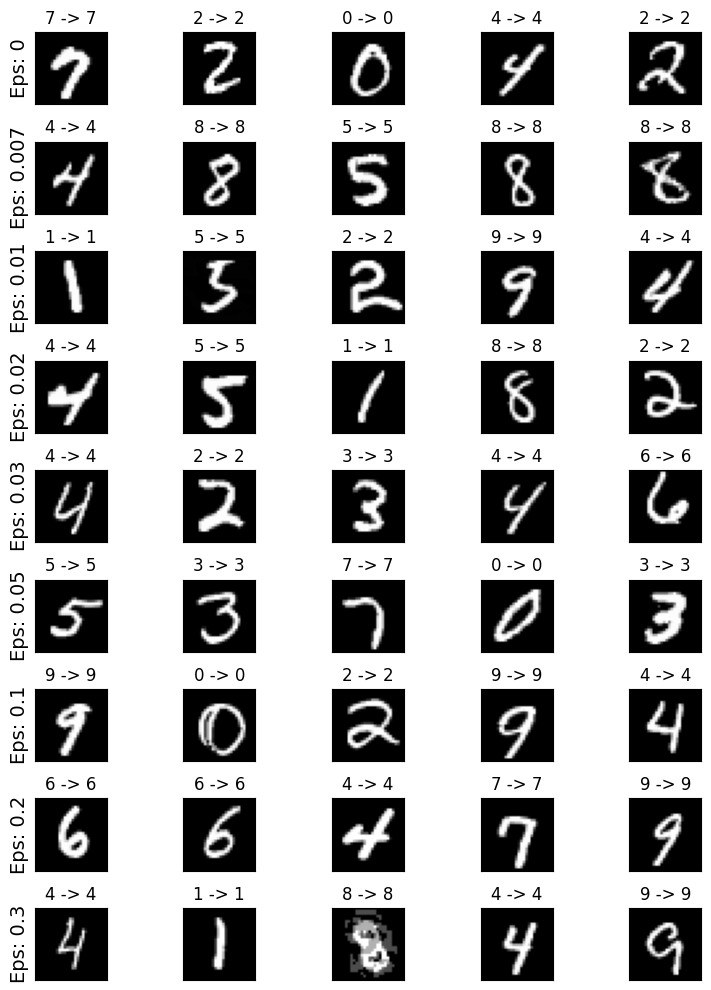

Epsilon: 0	Test Accuracy = 8592 / 10000 = 0.8592
Epsilon: 0.007	Test Accuracy = 8527 / 10000 = 0.8527
Epsilon: 0.01	Test Accuracy = 8621 / 10000 = 0.8621
Epsilon: 0.02	Test Accuracy = 8569 / 10000 = 0.8569
Epsilon: 0.03	Test Accuracy = 8570 / 10000 = 0.857
Epsilon: 0.05	Test Accuracy = 8520 / 10000 = 0.852
Epsilon: 0.1	Test Accuracy = 8475 / 10000 = 0.8475
Epsilon: 0.2	Test Accuracy = 8346 / 10000 = 0.8346
Epsilon: 0.3	Test Accuracy = 8244 / 10000 = 0.8244


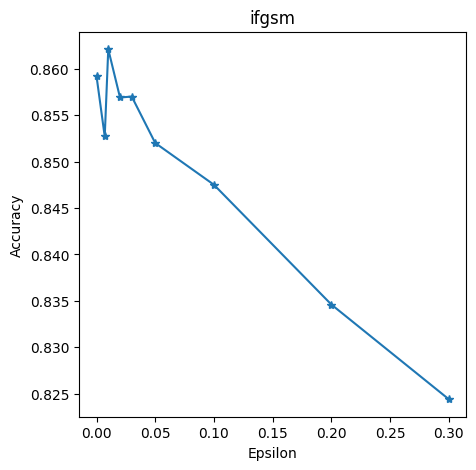

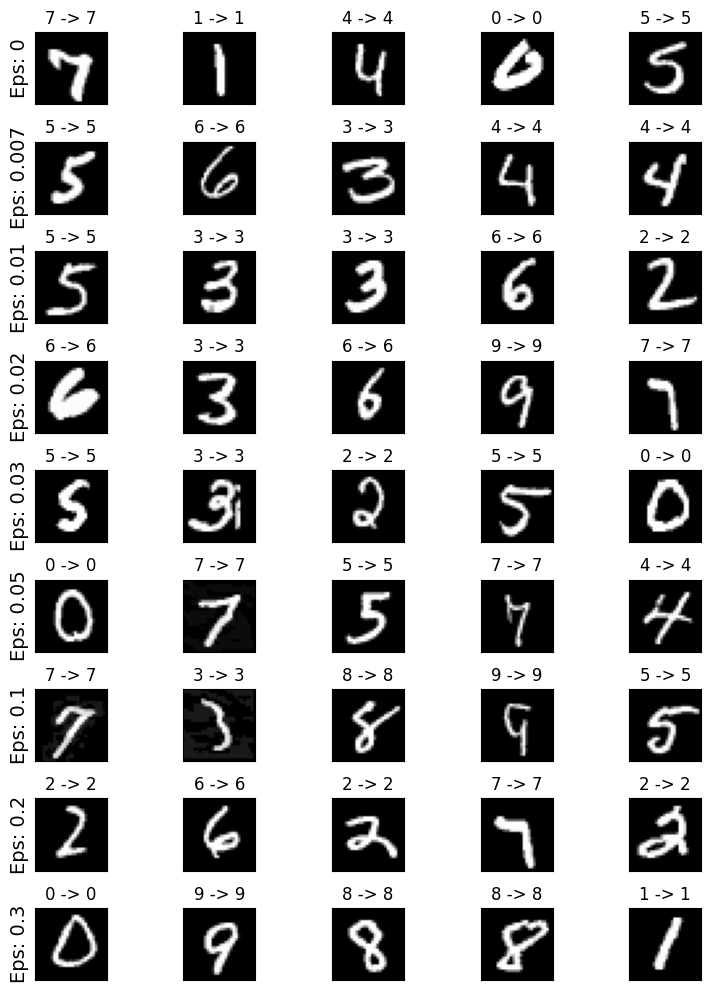

Epsilon: 0	Test Accuracy = 8584 / 10000 = 0.8584
Epsilon: 0.007	Test Accuracy = 8576 / 10000 = 0.8576
Epsilon: 0.01	Test Accuracy = 8613 / 10000 = 0.8613
Epsilon: 0.02	Test Accuracy = 8579 / 10000 = 0.8579
Epsilon: 0.03	Test Accuracy = 8564 / 10000 = 0.8564
Epsilon: 0.05	Test Accuracy = 8496 / 10000 = 0.8496
Epsilon: 0.1	Test Accuracy = 8478 / 10000 = 0.8478
Epsilon: 0.2	Test Accuracy = 8308 / 10000 = 0.8308
Epsilon: 0.3	Test Accuracy = 8256 / 10000 = 0.8256


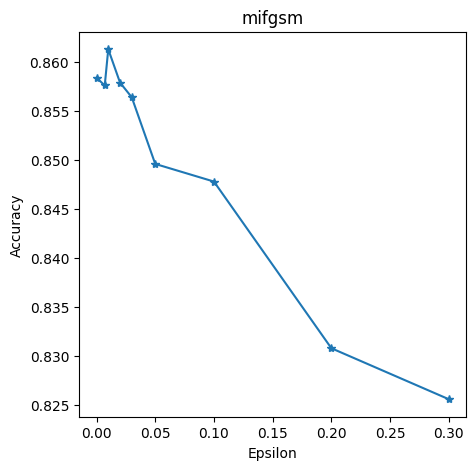

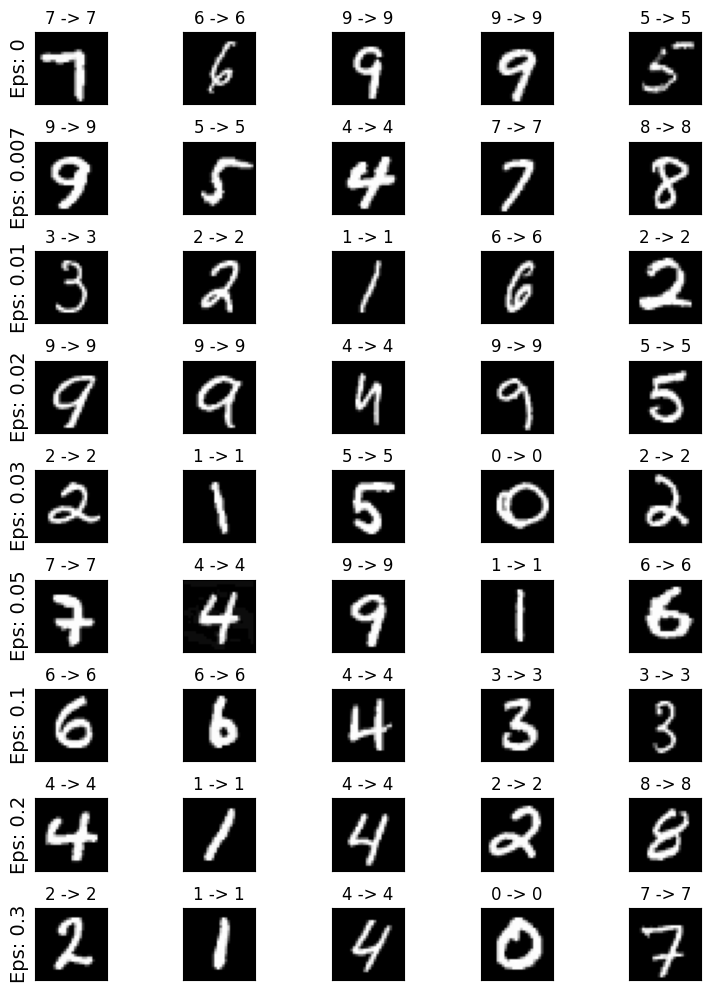

In [26]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)